source of data: [Abridged life tables by province](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B44&conn_path=I2&language=en), [	Abridged life tables](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B41&conn_path=I2&language=en),<br>[Life Tables for Korea, 2023 (PDF)](https://kostat.go.kr/board.es?mid=a20108060000&bid=11746&act=view&list_no=434451)<br>
[selection of colors](http://mal-bioit.ru/survey-web-colors)

wiki > [List of South Korean regions by life expectancy](https://en.wikipedia.org/wiki/List_of_South_Korean_regions_by_life_expectancy) / [Продолжительность жизни в регионах Республики Корея](https://ru.wikipedia.org/wiki/Продолжительность_жизни_в_регионах_Республики_Корея)

In [2]:
import pandas as pd
import math
import re

import sys
sys.path.append("..")
import mal_moduls_private.mal_total as mal

In [3]:
PROVINCE_1 = 'Gyeonggi-do'
PROVINCE_2 = 'Seoul'

In [4]:
df_provinces = pd.read_csv('data/South_Korea_2023 (UTF8).csv', skiprows=1,
                           usecols=["By province", "By age ",
                                    "Number of people left alive at age (Total) (Person)",
                                    "Number of people left alive at age (Male) (Person)",
                                    "Number of people left alive at age (Female) (Person)"
                                   ]
                          ) \
                 .rename(columns={"By province": "province",
                                  "By age ": "age",
                                  "Number of people left alive at age (Total) (Person)": "total",
                                  "Number of people left alive at age (Male) (Person)": "male",
                                  "Number of people left alive at age (Female) (Person)": "female"
                                 }
                        )

print(df_provinces.shape)
df_provinces.head()

(374, 5)


,province,age,total,male,female
0,Seoul,0,100000,100000,100000
1,Seoul,1,99800,99771,99831
2,Seoul,5,99764,99744,99787
3,Seoul,10,99745,99722,99769
4,Seoul,15,99689,99668,99712


In [5]:
def allocate_region_from_df(df_total, region):
    df_region = df_total.loc[df_total['province'] == region]
    df_region = df_region.set_index('age')[['male', 'total', 'female']]
    df_region.index.name = ''
    return df_region

df_region_1 = allocate_region_from_df(df_provinces, PROVINCE_1)
df_region_2 = allocate_region_from_df(df_provinces, PROVINCE_2)

print(df_region_1.shape)
df_region_1

(22, 3)


,male,total,female
,,,
0,100000,100000,100000
1,99791,99803,99815
5,99733,99744,99756
10,99692,99703,99715
15,99634,99650,99666
20,99498,99534,99571
25,99300,99376,99452
30,99029,99159,99290
35,98708,98904,99101


<br>

In [7]:
df_country = pd.read_csv('data/South_Korea_2023-whole_country (UTF8).csv', skiprows=1,
                           usecols=["By age",
                                    "Number of people left alive at age (Total)",
                                    "Number of people left alive at age (Male)",
                                    "Number of people left alive at age (Female)"
                                   ]
                          ) \
                 .rename(columns={"By age": "age",
                                  "Number of people left alive at age (Total)": "total",
                                  "Number of people left alive at age (Male)": "male",
                                  "Number of people left alive at age (Female)": "female"
                                 }
                        )

df_country.loc[:, 'age'] = df_country.loc[:, 'age'].map(lambda st: int(st.split(' ')[0]))

df_country = df_country.set_index('age')[['male', 'total', 'female']]
df_country.index.name = ''

print(df_country.shape)
df_country.head()

(22, 3)


,male,total,female
,,,
0,100000,100000,100000
1,99732,99758,99786
5,99673,99703,99734
10,99635,99666,99699
15,99582,99613,99646


<br>

In [9]:
# combine dataframes
df = pd.concat([df_country, df_region_1, df_region_2], axis='columns')

df.columns = ['male', 'total', 'female', 'male_r1', 'total_r1', 'female_r1', 'male_r2', 'total_r2', 'female_r2']

# delete redundant dataFrames
del df_country, df_provinces, df_region_1, df_region_2

df.insert(loc=3,  column='fΔm', value=df['female'] - df['male'])  # rounding is not used here since numbers are integers
df.insert(loc=4,  column='ratio_fm', value=(df['female'] / df['male']).round(2))

df.insert(loc=8,  column='fΔm_r1', value=df['female_r1'] - df['male_r1'])
df.insert(loc=9,  column='ratio_fm_r1', value=(df['female_r1'] / df['male_r1']).round(2))

df.insert(loc=13,  column='fΔm_r2', value=df['female_r2'] - df['male_r2'])
df.insert(loc=14,  column='ratio_fm_r2', value=(df['female_r2'] / df['male_r2']).round(2))

print(df.shape)
df.loc[[0, 1, 5, 65, 80, 90, 95, 100]]

(22, 15)


,male,total,female,fΔm,ratio_fm,male_r1,total_r1,female_r1,fΔm_r1,ratio_fm_r1,male_r2,total_r2,female_r2,fΔm_r2,ratio_fm_r2
,,,,,,,,,,,,,,,
0,100000,100000,100000,0,1.00,100000,100000,100000,0,1.00,100000,100000,100000,0,1.00
1,99732,99758,99786,54,1.00,99791,99803,99815,24,1.00,99771,99800,99831,60,1.00
5,99673,99703,99734,61,1.00,99733,99744,99756,23,1.00,99744,99764,99787,43,1.00
65,89007,91902,94798,5791,1.07,90075,92579,95083,5008,1.06,90365,92913,95462,5097,1.06
80,63640,72729,81819,18179,1.29,65254,73689,82125,16871,1.26,67765,76154,84544,16779,1.25
90,22445,33235,44024,21579,1.96,24341,34289,44238,19897,1.82,27420,39089,50759,23339,1.85
95,6799,13109,19419,12620,2.86,7903,13750,19598,11695,2.48,9789,17890,25991,16202,2.66
100,966,2794,4621,3655,4.78,1268,2985,4702,3434,3.71,1854,5000,8147,6293,4.39


In [10]:
df.loc[[0, 1, 5, 65, 80, 90, 95, 100], ['male', 'male_r1', 'male_r2', 'female', 'female_r1', 'female_r2']]

,male,male_r1,male_r2,female,female_r1,female_r2
,,,,,,
0,100000,100000,100000,100000,100000,100000
1,99732,99791,99771,99786,99815,99831
5,99673,99733,99744,99734,99756,99787
65,89007,90075,90365,94798,95083,95462
80,63640,65254,67765,81819,82125,84544
90,22445,24341,27420,44024,44238,50759
95,6799,7903,9789,19419,19598,25991
100,966,1268,1854,4621,4702,8147


In [11]:
def create_table(df, file_header, lang='en'):

    def transform_value(x, prec=1):
        return f"{x/1000:0.{prec}f}"

    
    with open('design/' + file_header, mode='r', encoding="utf-8") as fh:
        table_header = fh.read()

    st = ''
    for age in df.index.to_list()[1:]:
        ser = df.loc[age]

        st += '\n' + '|-\n' + \
            f'|style="padding-right:2ex;"| {age} ' + \
            f'||style="color:blue;padding-right:3ex;"| {transform_value(ser.loc['male'])} ' + \
            f'||style="color:red;padding-right:3ex;"| {transform_value(ser.loc['female'])} ' + \
            f'||style="color:darkgray;padding-right:3ex;"| {transform_value(ser.loc['fΔm'])} ' + \
            f'||style="color:darkgray;"| {ser.loc['ratio_fm']:0.2f} ' + \
            f'||style="color:blue;padding-right:3ex;border-left-width:2px;"| {transform_value(ser.loc['male_r1'])} ' + \
            f'||style="color:red;padding-right:3ex;"| {transform_value(ser.loc['female_r1'])} ' + \
            f'||style="color:darkgray;padding-right:3ex;"| {transform_value(ser.loc['fΔm_r1'])} ' + \
            f'||style="color:darkgray;"| {ser.loc['ratio_fm_r1']:0.2f} ' + \
            f'||style="color:blue;padding-right:3ex;border-left-width:2px;"| {transform_value(ser.loc['male_r2'])} ' + \
            f'||style="color:red;padding-right:3ex;"| {transform_value(ser.loc['female_r2'])} ' + \
            f'||style="color:darkgray;padding-right:3ex;"| {transform_value(ser.loc['fΔm_r2'])} ' + \
            f'||style="color:darkgray;"| {ser.loc['ratio_fm_r2']:0.2f}'

    if lang == 'ru':
        st = re.sub('(?<=\\d)\\.(?=\\d)', ',', st)  # replace . to comma, if this . is between two digits

    st = table_header + st + '\n|}'
    return st


# table_code = create_table(df, file_header='Perc_surviving_header_extended -ru.txt', lang='ru')
# with open('output/Table code for percentage surviving extended -ru.txt', 'w', encoding="utf-8") as fh:
#     fh.write(table_code)

# table_code = create_table(df, file_header='Perc_surviving_header_extended -en.txt', lang='en')
# with open('output/Table code for percentage surviving extended -en.txt', 'w', encoding="utf-8") as fh:
#     fh.write(table_code)

<br>
<br>
<br>

### making interpolation and creation of charts

In [13]:
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
from scipy.interpolate import PchipInterpolator

In [14]:
DESTINATION_CHART = 'show'  # to where table code should be placed: 'file', 'show'
LANG = 'en'                 # language of the chart (is setting doesn't have influence on tables)

In [15]:
DisplayedGroup = namedtuple('DisplayedGroup', ['en_name', 'ru_name', 'markerfacecolor', 'color', 'style', 'width', 'alpha'])

In [16]:
# this function allows to create quadratic, cubic and some kinds of interpolation,
# but I recided to stick to the PCHIP interpolation - implemented below.

# def interpolate_data(df):
#     age_new = np.arange(df.index.min(), df.index.max() + 1)

#     df_new = pd.DataFrame({'age': age_new})
#     df_new = df_new.set_index('age')

#     # Interpolate missing values using linear interpolation
#     method = 'quadratic'  # 'cubic'

#     df_new[['male', 'female']] = df[['male', 'female']].reindex(age_new).interpolate(method=method)
#     df_new.index.name = ''
    
#     return df_new


# df_interpolated = interpolate_data(df.loc[1:, ['male', 'female']] / 1000)
# df_interpolated = pd.concat([df.loc[[0], ['male', 'female']]/1000,
#                              df_interpolated],
#                             axis='index')
# df_interpolated.loc[[0, 1] + list(range(5, 101, 5))] \
#                .round(3)

In [17]:
# interpolation of data using PCHIP algorithm (Piecewise Cubic Hermite Interpolating Polynomial)

def interpolate_data_pchip(df):

    # Create PCHIP interpolator (Piecewise Cubic Hermite Interpolating Polynomial)
    pchip = PchipInterpolator(df.index, df[['male', 'female']])  #  df[['male', 'female']]

    # Create new age range (every year)
    age_new = np.arange(df.index.min(), df.index.max() + 1)

    # Interpolate
    percent_interpolated = pchip(age_new)

    # Create result DataFrame
    df_result = pd.DataFrame({
        'age': age_new,
        'male': [tp[0] for tp in percent_interpolated],
        'female': [tp[1] for tp in percent_interpolated],
    })

    # there's nuance that during this interpolation the last record obtains a tiny shift - fix this
    df_result.iloc[-1] = df_result.iloc[-1].round(14)

    df_result.set_index('age', inplace=True)
    df.index.name = ''
    return df_result


df_interpolated = interpolate_data_pchip(df.loc[1:, ['male', 'female']] / 1000)
df_interpolated = pd.concat([df.loc[[0], ['male', 'female']]/1000,
                             df_interpolated],
                            axis='index')
df_interpolated.loc[[0, 1, 5, 90, 95, 100]] \
               .round(3)

,male,female
0,100.000,100.000
1,99.732,99.786
5,99.673,99.734
90,22.445,44.024
95,6.799,19.419
100,0.966,4.621


In [18]:
# check that values in key points are intact during interpolation
# ALAS, there's an issue with the last record that I can't solve easily, so it is truncated and is checked manually

df_test = df_interpolated.loc[[0, 1] + list(range(5, 101, 5))]

assert df_test.equals(df.loc[:, ['male', 'female']] / 1000)

del df_test

<br>

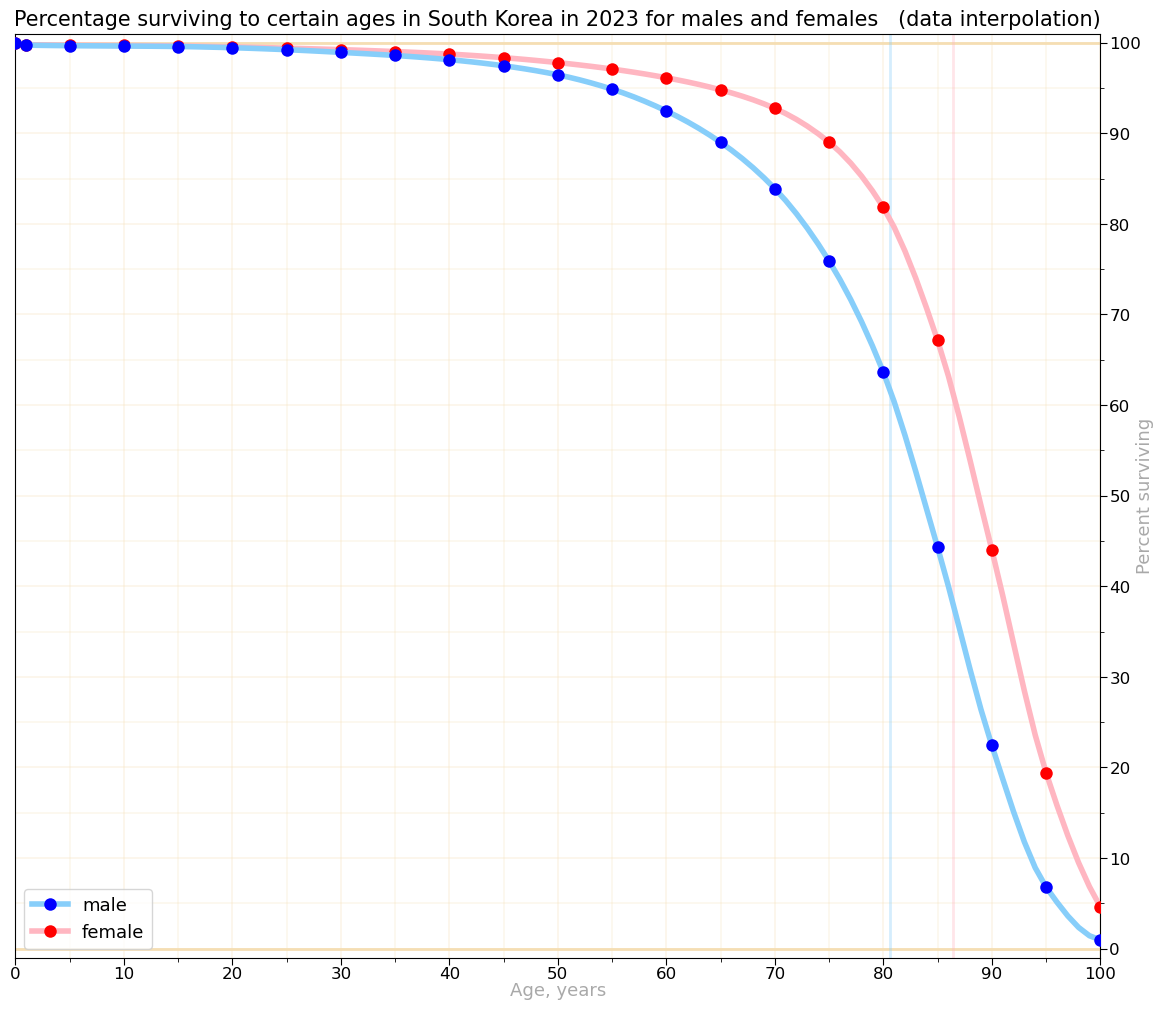

In [20]:
def create_chart(
        df, ls_markers_show=None, lang=LANG, dd_display='', ncol=2,
        title_en='Title of the chart', title_ru='Заголовок графика',
        le_male=None, le_female=None,
        destination=DESTINATION_CHART, file_name=''):

    plt.rcParams['figure.figsize'] = (14, 12)
    # plt.rcParams['figure.figsize'] = (15, 12.5) if lang=='ru' else (14, 12)
    
    fig, ax = plt.subplots()   # Create a figure and axis
    ax.yaxis.tick_right()  # show ticks only at the left side
    ax.yaxis.set_label_position("right")  # set the label position to the right 

    ax.xaxis.set_major_locator(MultipleLocator(10))   # Set major ticks to be multiples of 10
    ax.xaxis.set_minor_locator(MultipleLocator(5))    # Set minor ticks to be multiples of 5
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    # Customize tick lengths
    ax.tick_params(axis='x', which='major', length=5, pad=1.5)  # Major ticks are longer
    ax.tick_params(axis='x', which='minor', length=3)  # Minor ticks are shorter
    ax.tick_params(axis='y', which='major', length=5, pad=1.5)  # Major ticks are longer
    ax.tick_params(axis='y', which='minor', length=3)  # Minor ticks are shorter
    plt.xticks(fontsize=12)  # font size for tick labels
    plt.yticks(fontsize=12)
    
    x_min = y_min = 0
    x_max = 100
    y_max = 100
    plt.xlim(0, 100)
    plt.ylim(-1, 101)

    plt.grid(which='major', color='wheat', linewidth=0.35)
    plt.grid(which='minor', color='wheat', linewidth=0.3)

    plt.axhline(y=100, color='wheat', linewidth=2)
    plt.axhline(y=0, color='wheat', linewidth=2)

    plt.title(title_ru if lang=='ru' else title_en, fontsize=15)
    plt.xlabel('Возраст, годы' if lang=='ru' else 'Age, years', fontsize=13, color='darkgray', labelpad=-0.5)
    plt.ylabel('Процент выживших' if lang=='ru' else 'Percent surviving', fontsize=13, color='darkgray', labelpad=-3.5)
    # plt.ylabel('Доля выживших' if lang=='ru' else 'Survival Rate', fontsize=13, color='darkgray')  # , labelpad=-2

    if le_male:
        plt.axvline(x=le_male, color='lightskyblue', linewidth=2, alpha=0.35)
    if le_female:
        plt.axvline(x=le_female, color='lightpink', linewidth=2, alpha=0.35)
    
    for i, gr in enumerate(df.index.to_list()):
        ser = df.loc[gr]
        line_name = dd_display[gr].ru_name if lang=='ru' else dd_display[gr].en_name
        plt.plot(ser, color=dd_display[gr].color, linestyle=dd_display[gr].style,
                 linewidth=dd_display[gr].width, label=line_name, alpha=dd_display[gr].alpha, zorder=100-i,
                 marker='.', markerfacecolor=dd_display[gr].markerfacecolor, markeredgewidth=0,
                 markevery=ls_markers_show, markersize=18)
        # plt.plot(ser, color=dd_display[gr].color, linestyle=dd_display[gr].style,
        #          linewidth=dd_display[gr].width, label=line_name, alpha=dd_display[gr].alpha, zorder=100-i)

    plt.legend(loc='lower left', fontsize=13, ncol=ncol)

    if destination == 'file':
        plt.savefig(f"output_charts/{file_name}{' -ru' if lang=='ru' else ''}.png", bbox_inches='tight', facecolor='white', pad_inches=0.05)
        print('Data has written to file')
    else:
        plt.show()


dd_display = {
    'female'       : DisplayedGroup(en_name='female', ru_name='женщины', markerfacecolor='red', color='lightpink', style='-', width=4, alpha=1),
    'male'       : DisplayedGroup(en_name='male', ru_name='мужчины', markerfacecolor='blue', color='lightskyblue', style='-', width=4, alpha=1),
}

create_chart(df_interpolated.T,
             dd_display=dd_display, ls_markers_show=df.index.to_list(), ncol=1, lang=LANG,
             title_en='Percentage surviving to certain ages in South Korea in 2023 for males and females   (data interpolation)',
             title_ru='Процент выживших к определённому возрасту в Южной Корее в 2023   (интерполяция данных)',
             le_male=80.6, le_female=86.4,
             file_name='Percentage Surviving to Certain Ages in South Korea')

<br>

In [22]:
df_interpolated = interpolate_data_pchip(df.loc[1:, ['male_r1', 'female_r1']] \
                                           .rename(columns={'male_r1':'male', 'female_r1':'female'}) / 1000)
df_interpolated = pd.concat([df.loc[[0], ['male_r1', 'female_r1']].rename(columns={'male_r1':'male', 'female_r1':'female'})/1000,
                             df_interpolated],
                            axis='index')
df_interpolated.loc[[0, 1, 5, 90, 95, 100]] \
               .round(3)

,male,female
0,100.000,100.000
1,99.791,99.815
5,99.733,99.756
90,24.341,44.238
95,7.903,19.598
100,1.268,4.702


In [23]:
# check that values in key points are intact during interpolation
# ALAS, there's an issue with the last record that I can't solve easily, so it is truncated and is checked manually

df_test = df_interpolated.loc[[0, 1] + list(range(5, 101, 5))]

assert df_test.equals(df.loc[:, ['male_r1', 'female_r1']].rename(columns={'male_r1':'male', 'female_r1':'female'}) / 1000)

del df_test

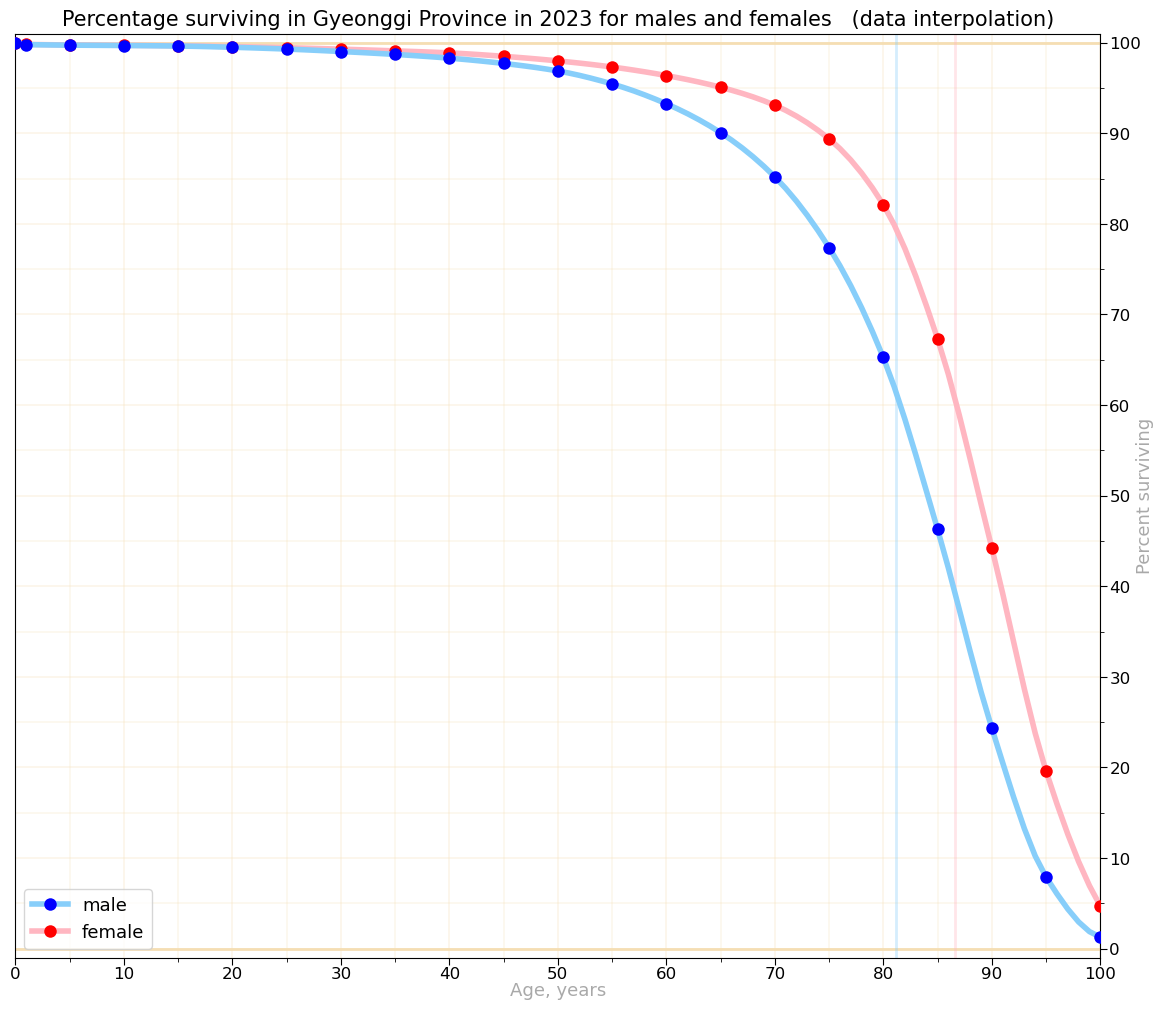

In [24]:
create_chart(df_interpolated.T,
             dd_display=dd_display, ls_markers_show=df.index.to_list(),ncol=1, lang=LANG,
             title_en='Percentage surviving in Gyeonggi Province in 2023 for males and females   (data interpolation)',
             title_ru='Процент выживших в провинции Кёнгидо в 2023   (интерполяция данных)',
             le_male=81.2, le_female=86.6,
             file_name='Percentage Surviving to Certain Ages in Gyeonggi Province')

<br>

In [26]:
df_interpolated = interpolate_data_pchip(df.loc[1:, ['male_r2', 'female_r2']] \
                                           .rename(columns={'male_r2':'male', 'female_r2':'female'}) / 1000)
df_interpolated = pd.concat([df.loc[[0], ['male_r2', 'female_r2']].rename(columns={'male_r2':'male', 'female_r2':'female'})/1000,
                             df_interpolated],
                            axis='index')
df_interpolated.loc[[0, 1, 5, 90, 95, 100]] \
               .round(3)

,male,female
0,100.000,100.000
1,99.771,99.831
5,99.744,99.787
90,27.420,50.759
95,9.789,25.991
100,1.854,8.147


In [27]:
# check that values in key points are intact during interpolation
# ALAS, there's an issue with the last record that I can't solve easily, so it is truncated and is checked manually

df_test = df_interpolated.loc[[0, 1] + list(range(5, 101, 5))]

assert df_test.equals(df.loc[:, ['male_r2', 'female_r2']].rename(columns={'male_r2':'male', 'female_r2':'female'}) / 1000)

del df_test

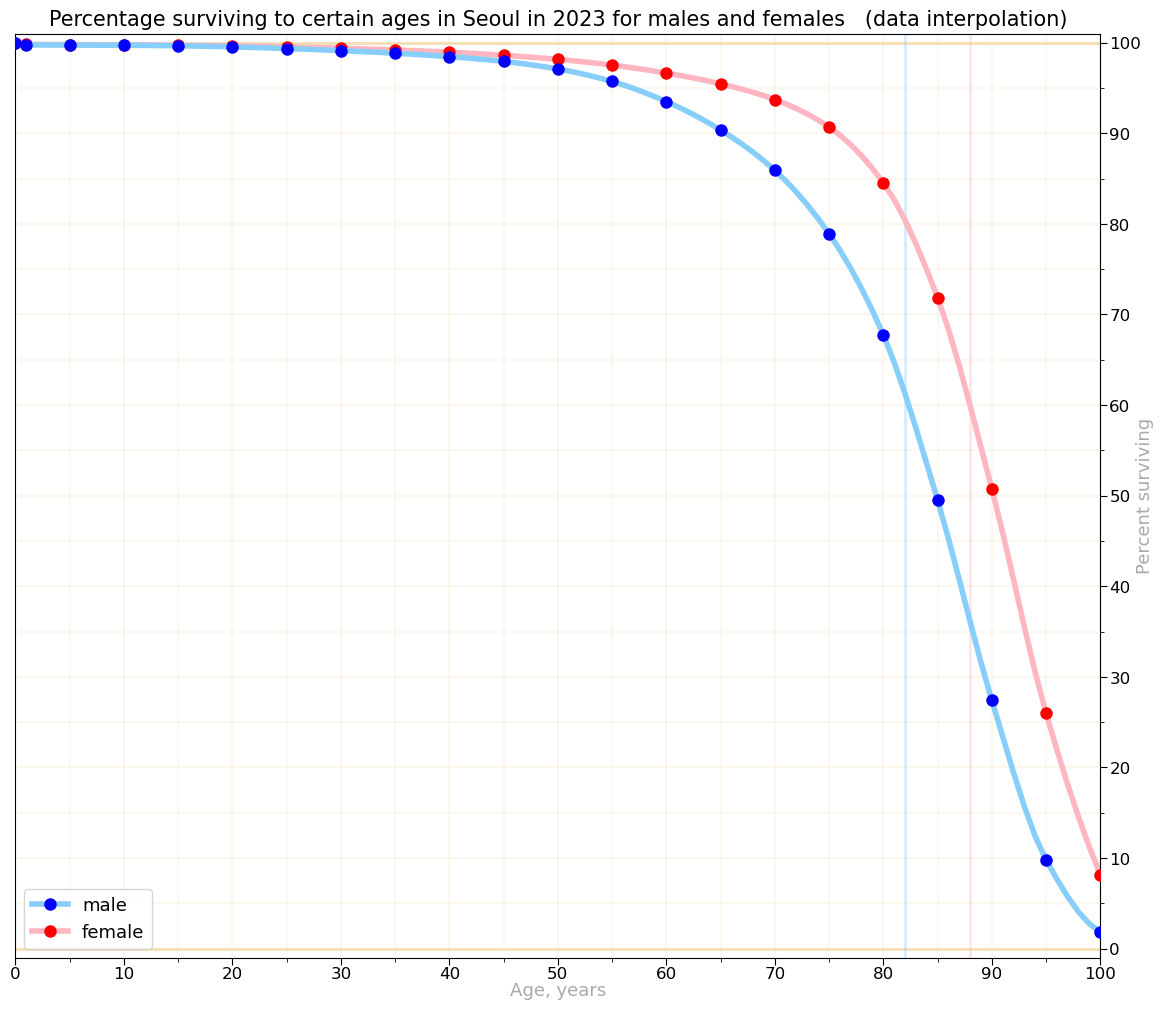

In [28]:
create_chart(df_interpolated.T,
             dd_display=dd_display, ls_markers_show=df.index.to_list(), ncol=1, lang=LANG,
             title_en='Percentage surviving to certain ages in Seoul in 2023 for males and females   (data interpolation)',
             title_ru='Процент выживших к определённому возрасту в Сеуле в 2023   (интерполяция данных)',
             le_male=82.0, le_female=88.0,
             file_name='Percentage Surviving to Certain Ages in Seoul')